In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from torchvision import datasets, transforms

from neural_networks import FashionMLP, FashionCNN

%matplotlib inline

# Helper functions

In [2]:
def plot_training_loss(history: dict) -> None:
    """Plot the training loss.

    Args:
        history (dict): Dictionary with loss and accuracy of train and validation set.
    """
    fig, ax = plt.subplots()
    ax.plot(history["epoch"], history["train_loss"], label="train set")
    ax.plot(history["epoch"], history["val_loss"], label="validation set")

    ax.set_title("Loss during training")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("loss")    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.legend()
    plt.show()

In [3]:
def plot_training_accuracy(history: dict) -> None:
    """Plot the training accuarcy.

    Args:
        history (dict): Dictionary with loss and accuracy of train and validation set.
    """
    fig, ax = plt.subplots()
    ax.plot(history["epoch"], history["train_acc"], label="training set")
    ax.plot(history["epoch"], history["val_acc"], label="validation set")

    ax.set_title("Accuracy during training")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("accuracy")    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.legend()
    plt.show()

# Download and normalize data

In [4]:
# Download train and test set
train = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.ToTensor())
test = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.ToTensor())

In [5]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# Multi Layer Perceptron

In [6]:
mlp = FashionMLP(hidden_dims=(512, 512, 512)) 
mlp_history = mlp.train(train, epochs=50, val_split=0.2)

Epoch  1/50: train_loss=1.012112, train_acc=0.6148, val_loss=0.723047, val_acc=0.7281
Epoch  2/50: train_loss=0.674878, train_acc=0.7479, val_loss=0.655590, val_acc=0.7572
Epoch  3/50: train_loss=0.586599, train_acc=0.7835, val_loss=0.598474, val_acc=0.7842
Epoch  4/50: train_loss=0.518627, train_acc=0.8108, val_loss=0.509085, val_acc=0.8162
Epoch  5/50: train_loss=0.473152, train_acc=0.8280, val_loss=0.459606, val_acc=0.8372
Epoch  6/50: train_loss=0.439967, train_acc=0.8397, val_loss=0.428194, val_acc=0.8462
Epoch  7/50: train_loss=0.415749, train_acc=0.8473, val_loss=0.423452, val_acc=0.8507
Epoch  8/50: train_loss=0.394644, train_acc=0.8550, val_loss=0.412726, val_acc=0.8517
Epoch  9/50: train_loss=0.378180, train_acc=0.8613, val_loss=0.384287, val_acc=0.8618
Epoch 10/50: train_loss=0.361503, train_acc=0.8660, val_loss=0.390923, val_acc=0.8604
Epoch 11/50: train_loss=0.352010, train_acc=0.8715, val_loss=0.374754, val_acc=0.8677
Epoch 12/50: train_loss=0.344381, train_acc=0.8742, va

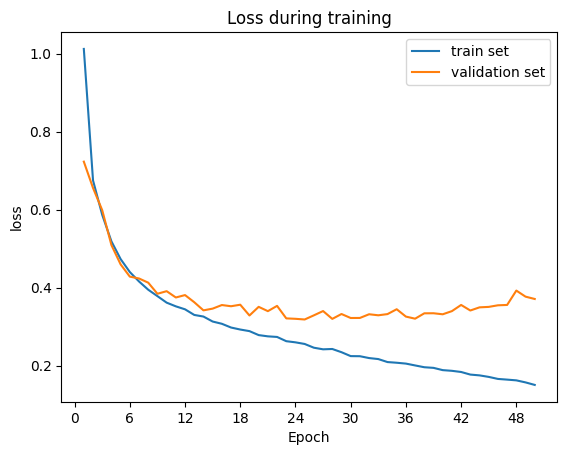

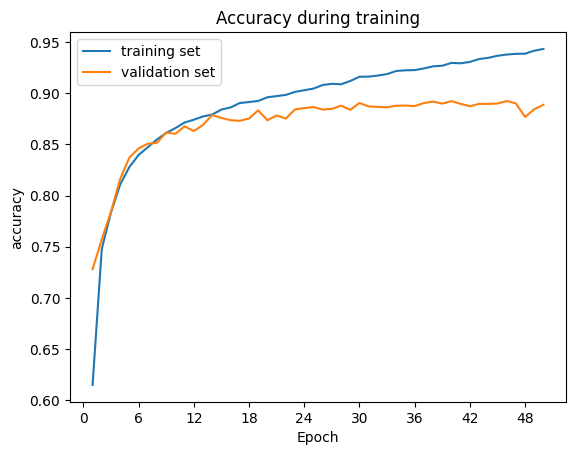

In [7]:
plot_training_loss(mlp_history)
plot_training_accuracy(mlp_history)

# Convolutional Neural Network

In [8]:
cnn = FashionCNN() 
cnn_history = cnn.train(train, epochs=50, val_split=0.2)

Epoch   1/50: train_loss=1.432292, train_acc=0.4575, val_loss=0.832183, val_acc=0.6877
Epoch   2/50: train_loss=0.733567, train_acc=0.7162, val_loss=0.707112, val_acc=0.7252
Epoch   3/50: train_loss=0.664302, train_acc=0.7411, val_loss=0.659028, val_acc=0.7442
Epoch   4/50: train_loss=0.629667, train_acc=0.7564, val_loss=0.646286, val_acc=0.7491
Epoch   5/50: train_loss=0.599071, train_acc=0.7695, val_loss=0.608657, val_acc=0.7688
Epoch   6/50: train_loss=0.567644, train_acc=0.7831, val_loss=0.572528, val_acc=0.7798
Epoch   7/50: train_loss=0.543523, train_acc=0.7956, val_loss=0.569817, val_acc=0.7866
Epoch   8/50: train_loss=0.517767, train_acc=0.8070, val_loss=0.533798, val_acc=0.7997
Epoch   9/50: train_loss=0.495989, train_acc=0.8157, val_loss=0.507981, val_acc=0.8079
Epoch  10/50: train_loss=0.481425, train_acc=0.8205, val_loss=0.498342, val_acc=0.8139
Epoch  11/50: train_loss=0.464260, train_acc=0.8269, val_loss=0.480285, val_acc=0.8139
Epoch  12/50: train_loss=0.450644, train_ac

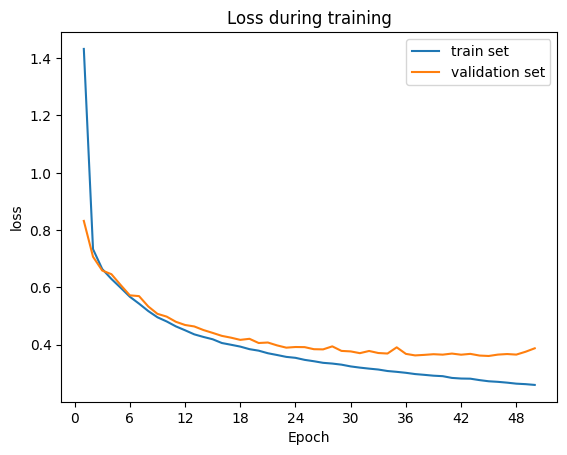

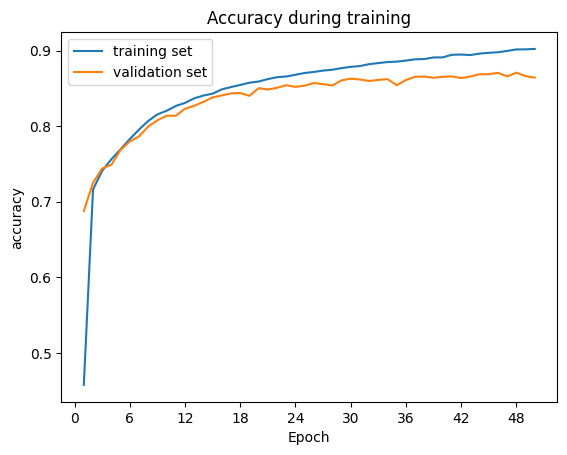

In [9]:
plot_training_loss(cnn_history)
plot_training_accuracy(cnn_history)

# Vision Transformer

In [10]:
# TODO

# Summary

In [11]:
# TODO